<img src=images/vqd.png>

In [1]:
import qiskit_nature
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import Psi4Driver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper
qiskit_nature.settings.use_pauli_sum_op = False

mol = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["H", "H"],
    coords=([0.0, 0.0, -0.3625], [0.0, 0.0, 0.3625]),
    multiplicity=1,
    charge=0,
)

prob_unmod = Psi4Driver.from_molecule(mol).run()

problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(prob_unmod)

num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

mapper = ParityMapper(num_particles=num_particles)  # Set Mapper

hamiltonian = mapper.map(problem.second_q_ops()[0])  # Set Hamiltonian

print(hamiltonian)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05016043+0.j,  0.40421466+0.j, -0.40421466+0.j, -0.01134688+0.j,
  0.18037525+0.j])


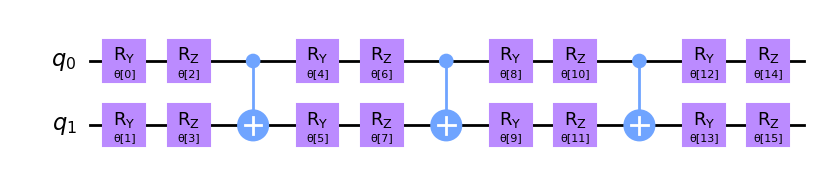

In [2]:
from qiskit.circuit.library import EfficientSU2
#ansatz = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz')
ansatz = EfficientSU2(hamiltonian.num_qubits)

from qiskit.algorithms.optimizers import SLSQP
optimizer = SLSQP(maxiter=150, max_evals_grouped=1)

ansatz.decompose().draw('mpl')

In [3]:
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute

estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

ComputeUnCompute uses the sampler primitive to calculate the state fidelity of two quantum circuits following the compute-uncompute method

fedility (state overlap): <img src=images/cuc_sol.png />

The initial release of Qiskit Runtime includes two primitives:

Sampler: Generates quasi-probability distribution from input circuits.

Estimator: Calculates expectation values from input circuits and observables.

In [4]:
k = 4
betas = [33,33,33,33]

In [5]:
counts = []
values = []
steps = []

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

<img src=images/vqd_cost.png>

In [6]:
from qiskit.algorithms.eigensolvers import VQD


vqd = VQD(estimator, fidelity, ansatz, optimizer, k=k, betas=betas, callback=callback)
result = vqd.compute_eigenvalues(operator = hamiltonian)
vqd_values = result.eigenvalues

In [7]:
print(vqd_values.real)

[-1.86712097 -1.24188254 -0.88113169 -0.21050596]


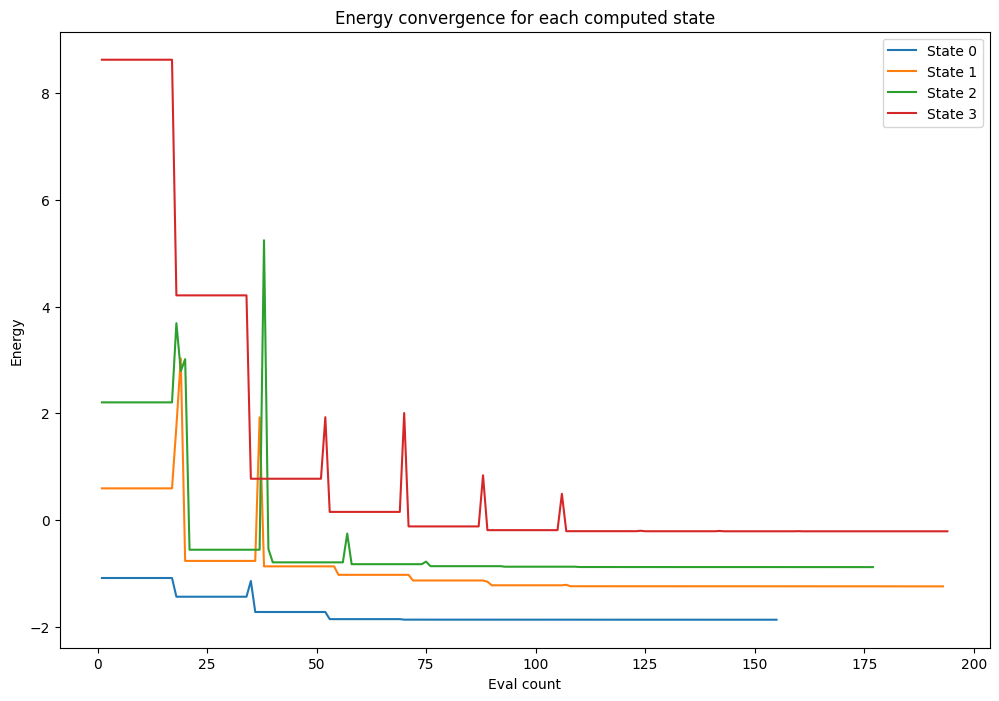

In [8]:
import numpy as np
import matplotlib.pyplot as plt
g1=plt

g1.rcParams["figure.figsize"] = (12, 8)

steps = np.asarray(steps)
counts = np.asarray(counts)
values = np.asarray(values)

for i in range(1,5):
    _counts = counts[np.where(steps == i)]
    _values = values[np.where(steps == i)]
    g1.plot(_counts, _values, label=f"State {i-1}")

g1.xlabel("Eval count")
g1.ylabel("Energy")
g1.title("Energy convergence for each computed state")
g1.legend(loc="upper right")
g1.show()

In [9]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver


exact_solver = NumPyEigensolver(k=4)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
ref_values = exact_result.eigenvalues

In [10]:
print(f"Reference values: {ref_values}")
print(f"VQD values: {vqd_values.real}")

Reference values: [-1.86712098 -1.24188257 -0.88113207 -0.21050612]
VQD values: [-1.86712097 -1.24188254 -0.88113169 -0.21050596]


In [11]:
print('errors in final VQD values (x 10^-8): ')
for i in range(0,4):
    print('state', i, ':', (abs(vqd_values.real-ref_values) * 10**8)[i])

errors in final VQD values (x 10^-8): 
state 0 : 1.2845639441039225
state 1 : 2.069316917818753
state 2 : 37.753599502199364
state 3 : 16.311304948390948


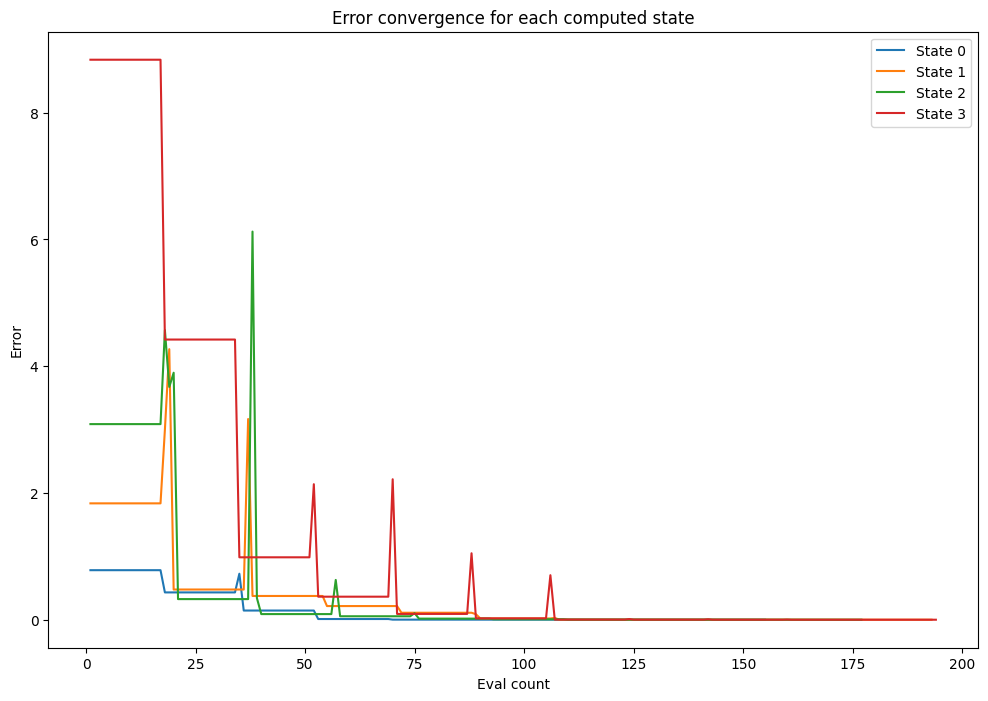

In [12]:
import numpy as np
import matplotlib.pyplot as plt

g2 = plt
g2.rcParams["figure.figsize"] = (12, 8)

steps = np.asarray(steps)
counts = np.asarray(counts)
values = np.asarray(values)

for i in range(1,5):
    _counts2 = counts[np.where(steps == i)]
    _values2 = -(-values[np.where(steps == i)] + ref_values[i-1])
    g2.plot(_counts2, _values2, label=f"State {i-1}")

g2.xlabel("Eval count")
g2.ylabel("Error")
g2.title("Error convergence for each computed state")
g2.legend(loc="upper right")
g2.show()